In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
import shap


# Load the dataset
file_path = 'C:\\Users\\13346\\OneDrive\\Desktop\\delhivery_data.csv'

df = pd.read_csv(file_path)

# Preview the data
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


In [2]:
# Basic info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

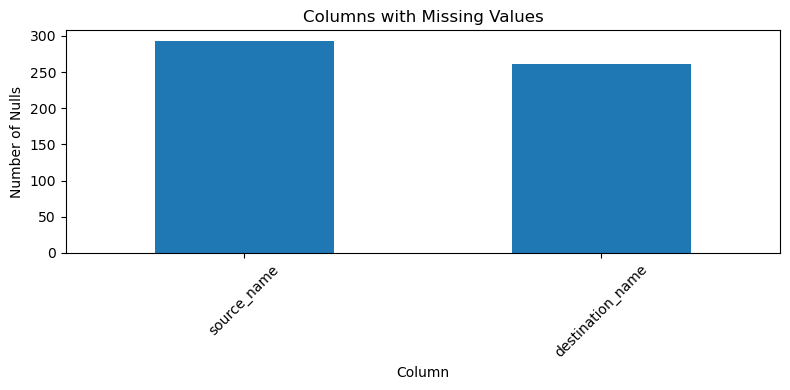

In [3]:
# Total missing values per column
df.isnull().sum()


# Step 1: Get columns with missing values
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]  # keep only columns with nulls

# Step 2: Plot
plt.figure(figsize=(8, 4))
null_counts.plot(kind='bar')
plt.title('Columns with Missing Values')
plt.xlabel('Column')
plt.ylabel('Number of Nulls')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
#Null investigation
# Filter rows where either source_name or destination_name is null
null_rows = df[df['source_name'].isnull() | df['destination_name'].isnull()]

# How many total null rows?
print(f"Total rows with nulls: {len(null_rows)}")

# Preview these rows
null_rows[['trip_creation_time', 'source_center', 'destination_center', 'route_type']].head()


Total rows with nulls: 551


,trip_creation_time,source_center,destination_center,route_type
110,2018-09-25 08:53:04.377810,IND342601AAA,IND342902A1B,FTL
111,2018-09-25 08:53:04.377810,IND342601AAA,IND342902A1B,FTL
112,2018-09-25 08:53:04.377810,IND342902A1B,IND302014AAA,FTL
113,2018-09-25 08:53:04.377810,IND342902A1B,IND302014AAA,FTL
114,2018-09-25 08:53:04.377810,IND342902A1B,IND302014AAA,FTL


In [5]:
# All 551 null rows have the exact same trip_creation_time and are clustered around a few specific source/destination centers.
# This strongly suggests:These nulls are likely from a single batch of trips created at the same time (possibly a system glitch or incomplete logging).
#The centers are also clustered (IND342601AAA, IND342902A1B, etc.),The route_type is consistently FTL

null_rows['trip_creation_time'].nunique()

null_rows['trip_creation_time'].value_counts().head(5)


trip_creation_time
2018-09-24 23:25:39.732847    14
2018-09-25 09:18:45.016913    14
2018-09-27 09:57:22.407682    14
2018-10-03 09:06:06.690094    14
2018-09-29 09:13:40.263937    14
Name: count, dtype: int64

In [6]:
print(null_rows['source_center'].nunique(), "unique source centers")
print(null_rows['destination_center'].nunique(), "unique destination centers")

null_rows['source_center'].value_counts()
null_rows['destination_center'].value_counts()


33 unique source centers
29 unique destination centers


destination_center
IND282002AAD    151
IND302014AAA     90
IND474003AAA     49
IND205001AAB     42
IND281004AAA     20
IND131301AAA     20
IND518002AAA     17
IND577101AAA     16
IND577116AAA     16
IND342902A1B     16
IND852118A1B     15
IND505326AAB     11
IND126116AAA     10
IND204101AAA      9
IND509103AAC      9
IND250002AAC      9
IND841301AAC      9
IND110037AAM      8
IND122015AAC      8
IND841226AAB      5
IND462022AAA      4
IND465333A1B      3
IND854326AAB      3
IND331001A1C      3
IND505327AAA      2
IND465333AAA      2
IND505425AAA      2
IND221005A1A      1
IND505001AAB      1
Name: count, dtype: int64

In [7]:
#Null Investigation Conclusion: Nulls Are Not Random: They are clustered in batches — e.g., 14 records each created at the exact same second.There are only 33 unique source centers and 29 unique destination centers affected. 
#One source center (IND282002AAD) alone has 151 null rows.Others follow in similarly sized clusters.
#Possible cause: The nulls likely stem from system-level issues such as a failed API call or a failed batch process. 

#Fix for this issue is to use ID's instead of Names-Drop Names
df = df.drop(['source_name', 'destination_name'], axis=1)

In [8]:
print(f"Shape: {df.shape}")
df.describe(include='all').T


Shape: (144867, 22)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
data,144867,2,training,104858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trip_creation_time,144867,14817,2018-09-22 04:55:04.835022,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route_schedule_uuid,144867,1504,thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...,1812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route_type,144867,2,FTL,99660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trip_uuid,144867,14817,trip-153759210483476123,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source_center,144867,1508,IND000000ACB,23347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination_center,144867,1481,IND000000ACB,15192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
od_start_time,144867,26369,2018-09-21 18:37:09.322207,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
od_end_time,144867,26369,2018-09-24 09:59:15.691618,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_scan_to_end_scan,144867.0,NaN,NaN,NaN,961.262986,1037.012769,20.0,161.0,449.0,1634.0,7898.0


In [9]:
#Target Variables Analysis
# Create binary target feature is_delayed
df['is_delayed'] = (df['actual_time'] > df['osrm_time']).astype(int)

#Create continuous target feature delay_minutes
df['delay_minutes'] = df['actual_time'] - df['osrm_time']

# Preview
df[['actual_time', 'osrm_time', 'delay_minutes', 'is_delayed']].head()

,actual_time,osrm_time,delay_minutes,is_delayed
0,14.0,11.0,3.0,1
1,24.0,20.0,4.0,1
2,40.0,28.0,12.0,1
3,62.0,40.0,22.0,1
4,68.0,44.0,24.0,1


In [10]:
# Convert to Datetime
df['trip_creation_time'] = pd.to_datetime(df['trip_creation_time'])
df['od_start_time'] = pd.to_datetime(df['od_start_time'])
df['od_end_time'] = pd.to_datetime(df['od_end_time'])

# Extract time-based features
df['trip_hour'] = df['trip_creation_time'].dt.hour
df['trip_dayofweek'] = df['trip_creation_time'].dt.day_name()
df['trip_month'] = df['trip_creation_time'].dt.month


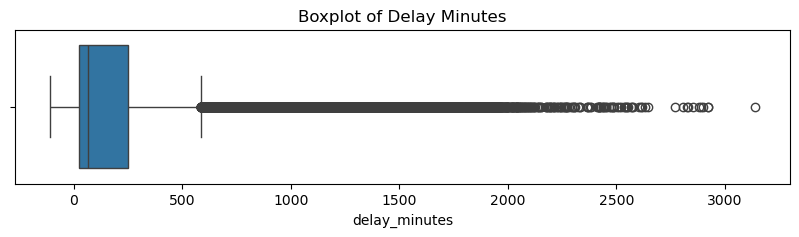

In [11]:
# Summary stats
df['delay_minutes'].describe()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['delay_minutes'])
plt.title('Boxplot of Delay Minutes')
plt.show()


In [12]:
# We have extreme right skew in our continuous variable delay_minutes. The upper bound of the IQR range is 500-700 minutes and everything beyond this is considered an outlier. Next step is to cap the outliers using Winsorization. 
# Calculate IQR
q1 = df['delay_minutes'].quantile(0.25)
q3 = df['delay_minutes'].quantile(0.75)
iqr = q3 - q1

# Bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Cap values
df['delay_minutes_capped'] = df['delay_minutes'].clip(lower=lower_bound, upper=upper_bound)


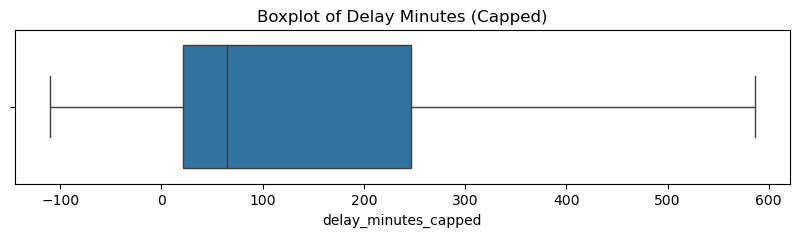

In [13]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['delay_minutes_capped'])
plt.title('Boxplot of Delay Minutes (Capped)')
plt.show()


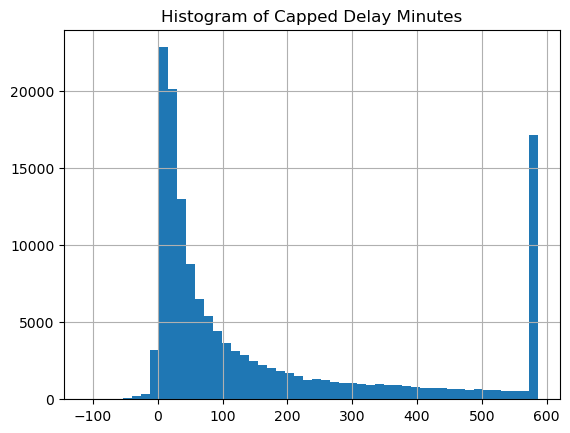

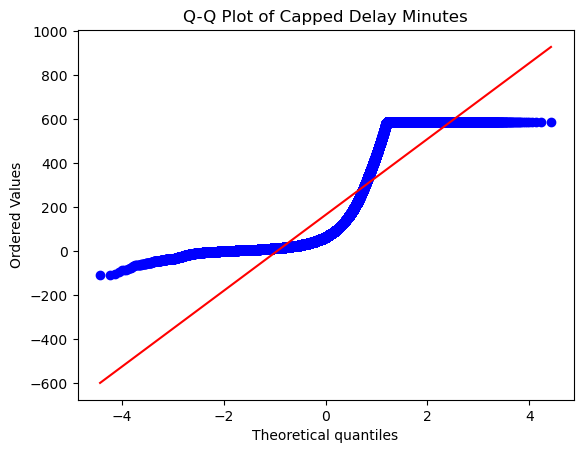

Shapiro-Wilk Test: Stat=0.753, p=0.00000


In [14]:
#Checking normality of capped values

# Histogram
df['delay_minutes_capped'].hist(bins=50)
plt.title("Histogram of Capped Delay Minutes")
plt.show()

# Q-Q plot
probplot(df['delay_minutes_capped'].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Capped Delay Minutes")
plt.show()

# Shapiro-Wilk test (use sample if dataset is large)
sample = df['delay_minutes_capped'].dropna().sample(3000, random_state=42)
stat, p = shapiro(sample)
print(f"Shapiro-Wilk Test: Stat={stat:.3f}, p={p:.5f}")

In [15]:
#Even after the initial capping, there is still a right skew. The spike at 600 is from winsorization. The Q-Q plot confirms non-normal distribution, even after capping. 
#Next Step is Log Transformation dur to the extreme right skew and  extreme outliers.

# Only apply log1p to valid (non-negative) values
df['delay_log'] = df['delay_minutes_capped'].apply(lambda x: np.log1p(x) if x >= 0 else np.nan)


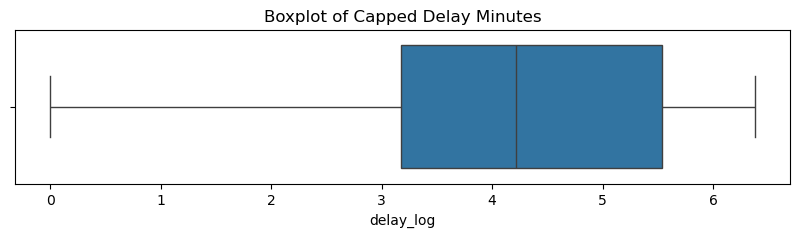

In [16]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['delay_log'])
plt.title('Boxplot of Capped Delay Minutes')
plt.show()

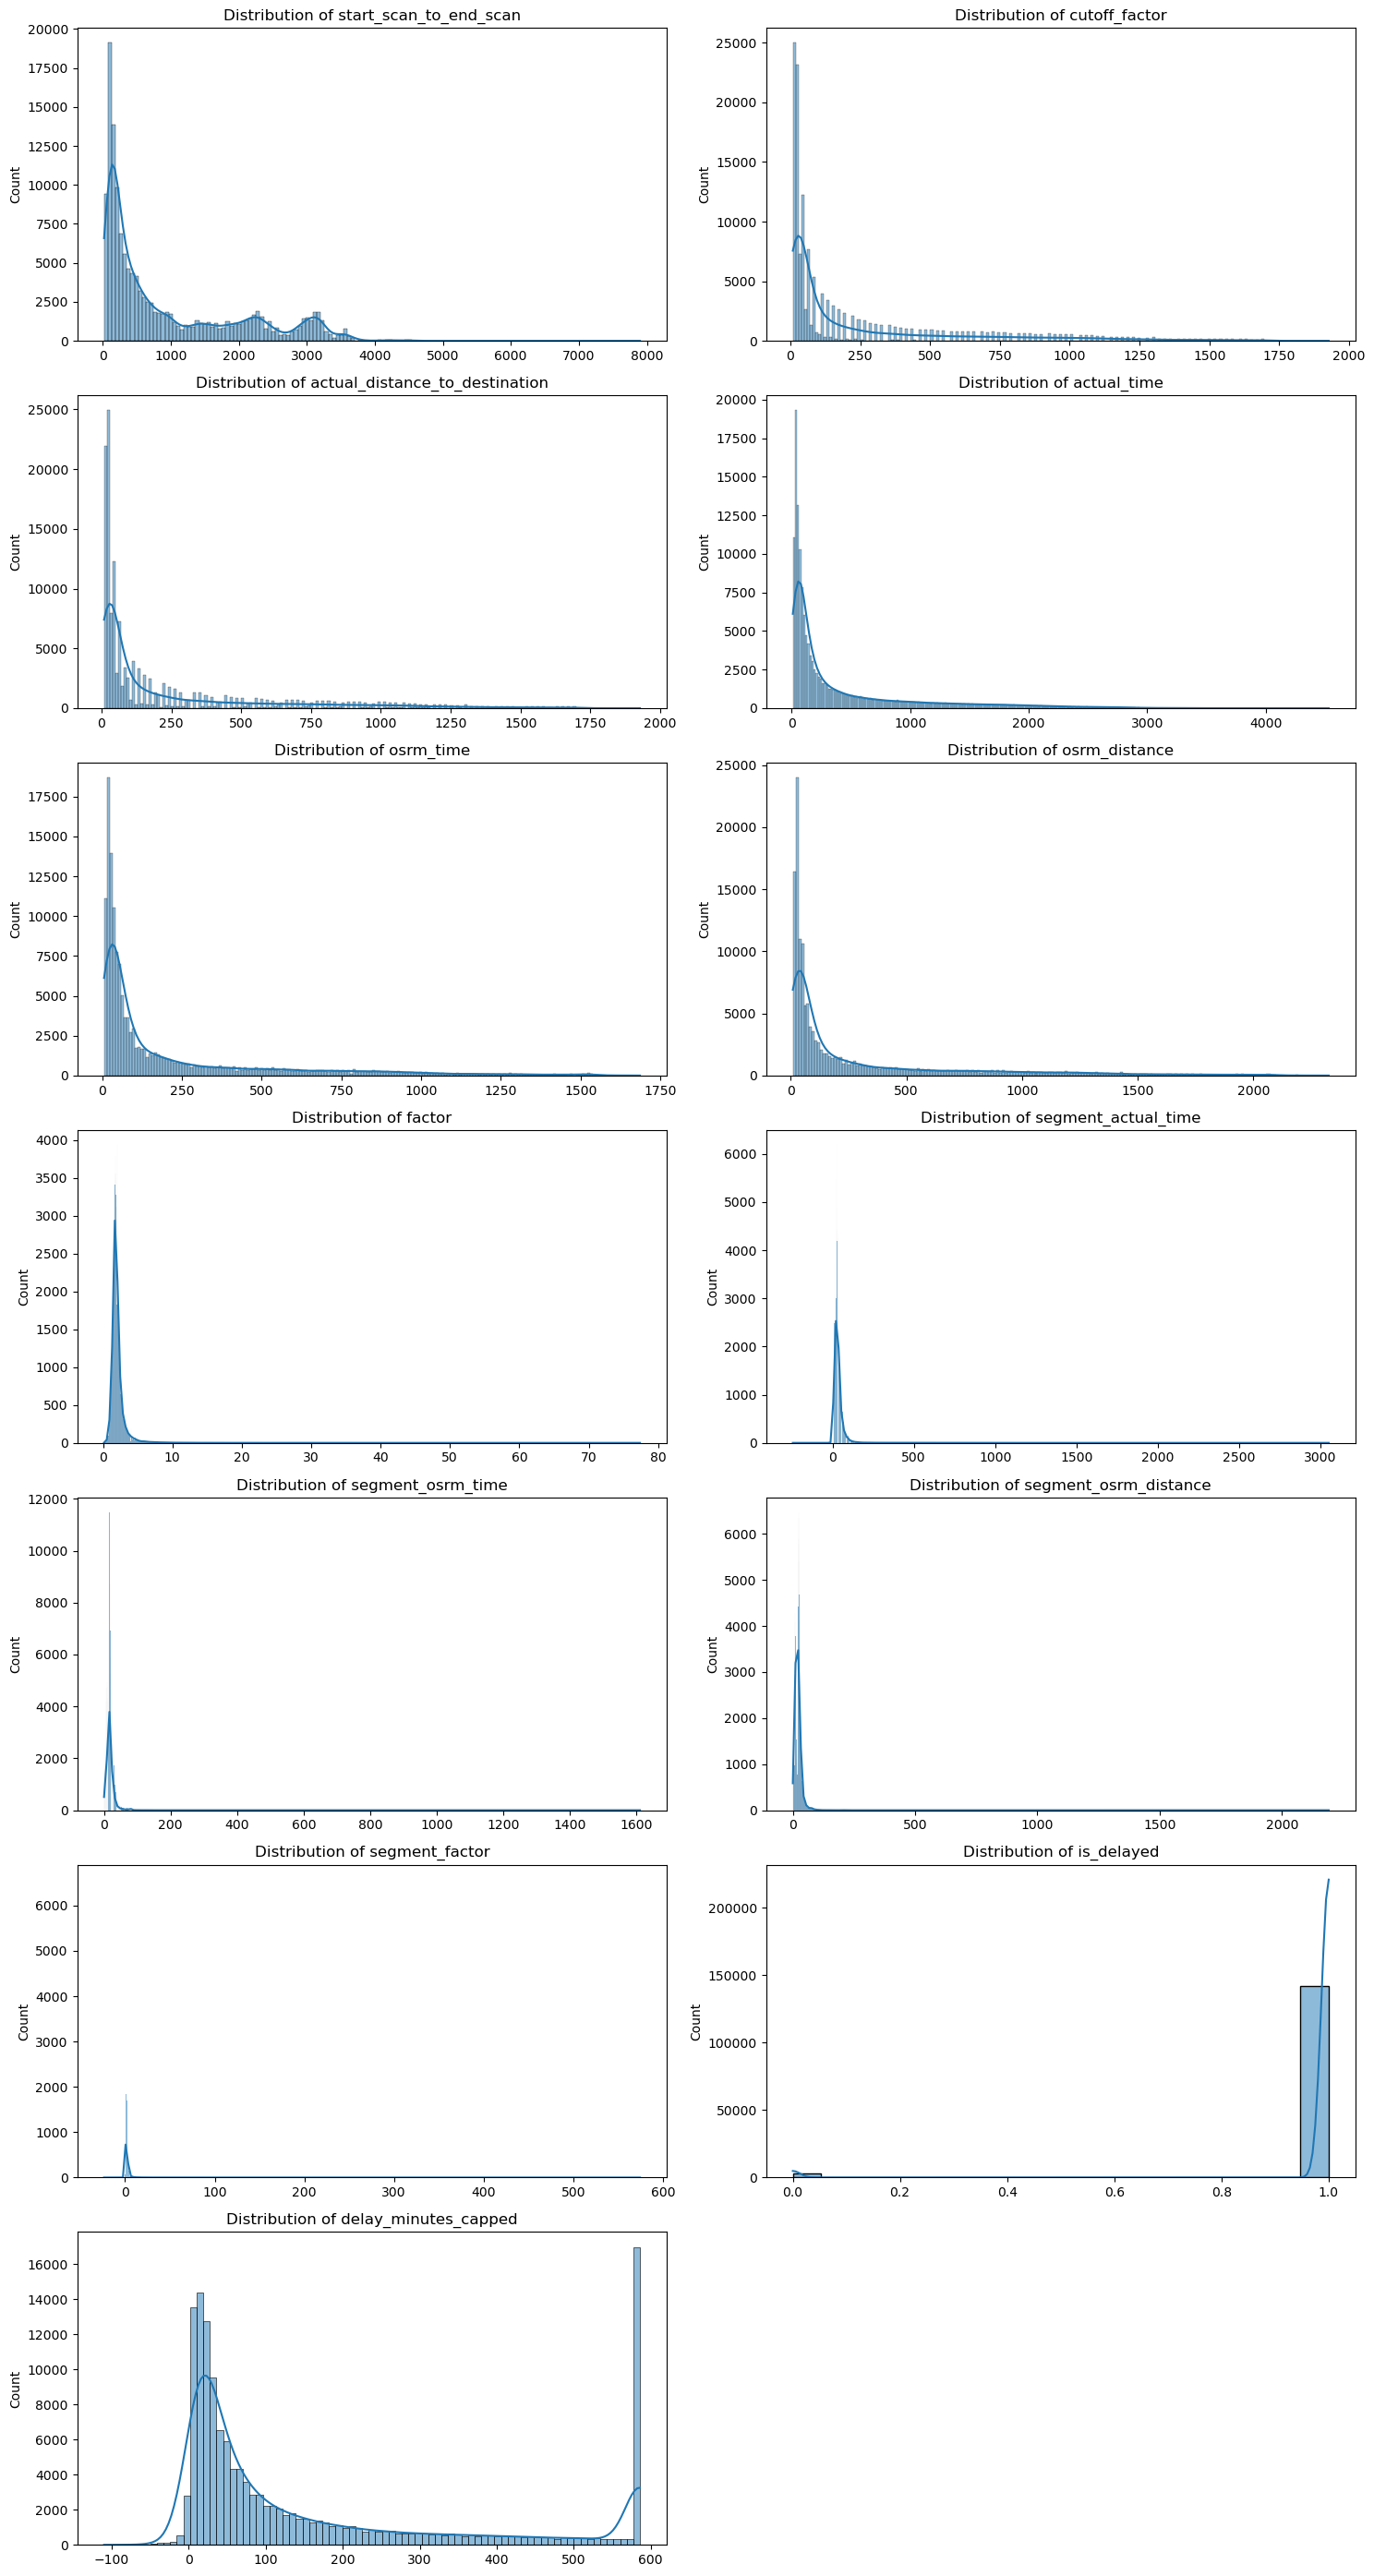

In [17]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Drop delay-related columns (already analyzed)
cols_to_plot = numeric_cols.drop(['delay_minutes', 'delay_log']) if 'delay_log' in numeric_cols else numeric_cols.drop(['delay_minutes'])

# Set up the figure
fig, axes = plt.subplots(nrows=len(cols_to_plot) // 2 + 1, ncols=2, figsize=(15, 4 * (len(cols_to_plot)//2 + 1)))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col].dropna(), ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    
# Hide any unused plots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

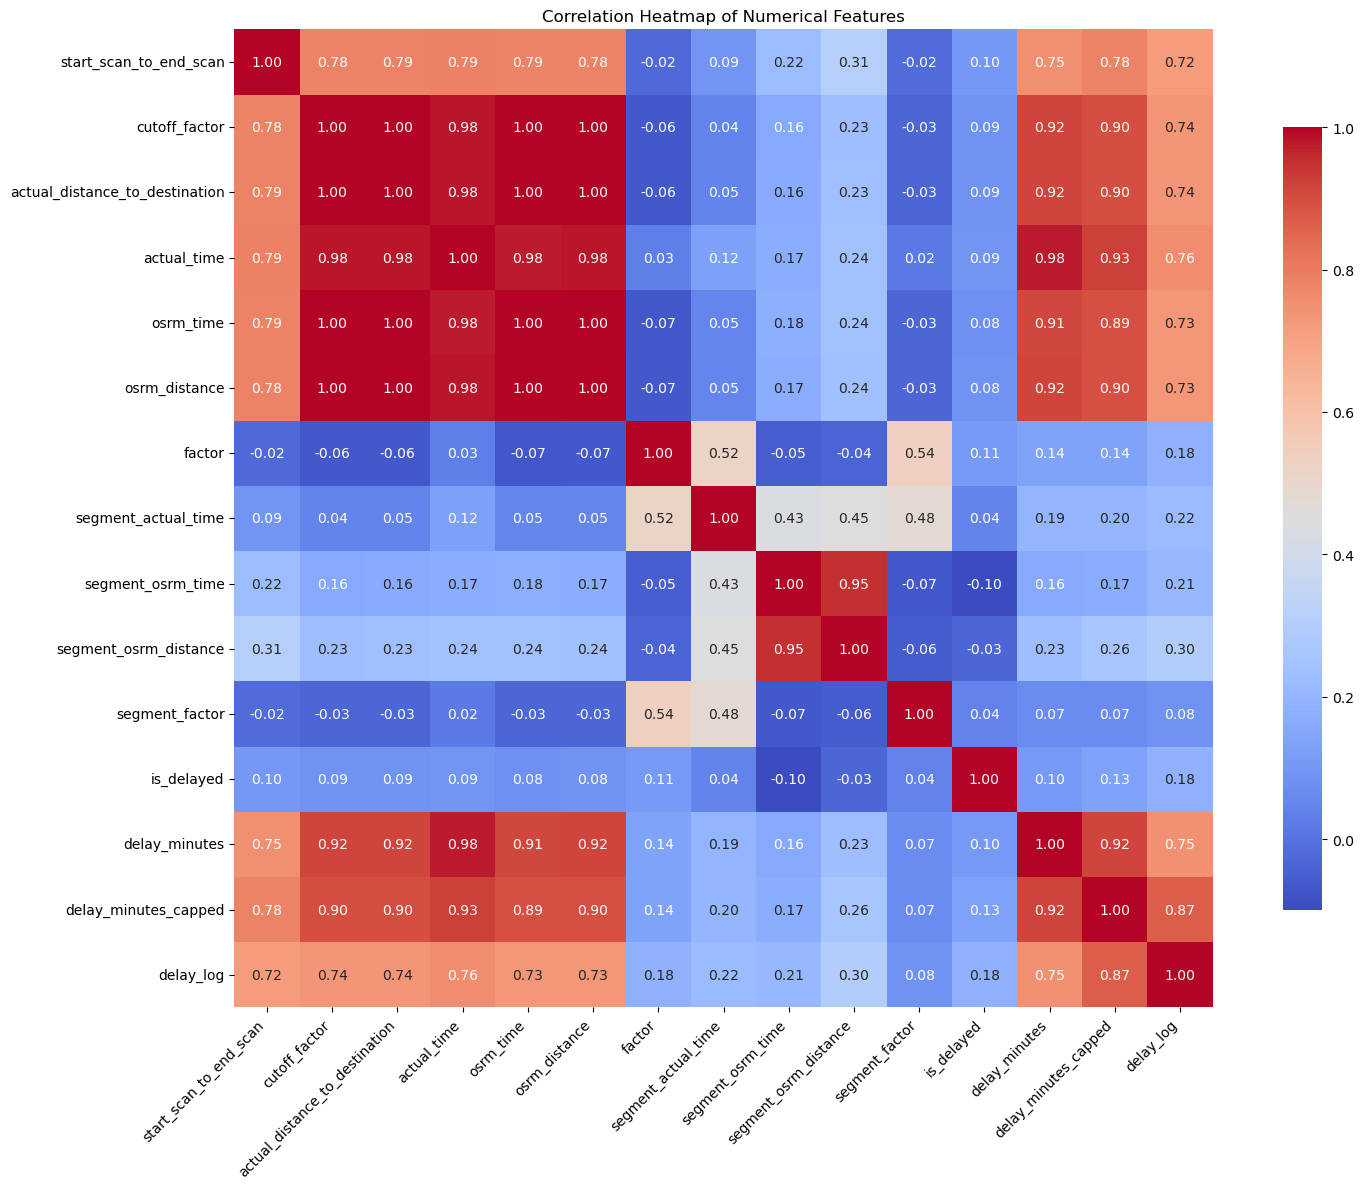

In [18]:
#Even though there continues to be some skewnewss in the variables, I am going to continue with EDA and look at a correlation heatmap due to the possibility of linear relationships between variales. 
# Select only numeric features for correlation
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Set up the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
#Key observations: Highly Correlated Features (Correlation > 0.9): cutoff_factor, actual_distance_to_destination, osrm_time, osrm_distance, and actual_time are almost perfectly correlated.
#Most likely do not need all of these in  model—might introduce multicollinearity.
# Low Correlation Features:trip_hour and trip_month show very weak correlation with the target. They might still hold some interaction effects but won't help much as standalone predictors.
# Target Feature:  delay_minutes is the base target,  already engineered delay_minutes_capped and delay_log, which show slightly reduced but still strong correlation (0.87 and 0.75, respectively). That’s expected due to transformation and capping.

#Next steps: Create Deltas/Ratios
#Time Delta
df['time_diff_vs_osrm'] = df['actual_time'] - df['osrm_time']

#Distance Delta
df['distance_diff_vs_osrm'] = df['actual_distance_to_destination'] - df['osrm_distance']

#Efficiency Ratio
df['time_per_km'] = df['actual_time'] / df['actual_distance_to_destination']

#Performance Ratio
df['osrm_time_ratio'] = df['actual_time'] / df['osrm_time']



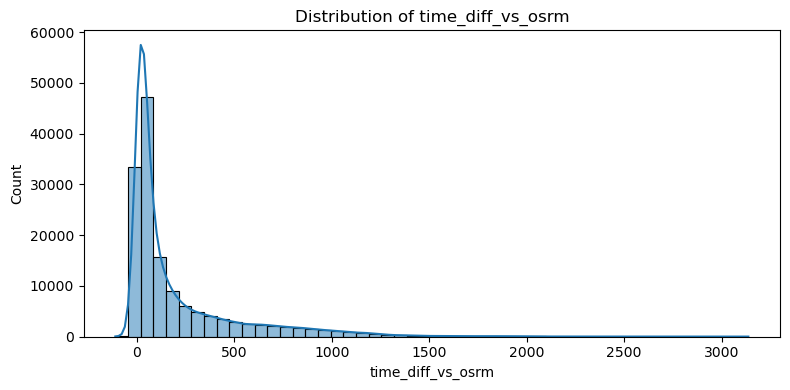

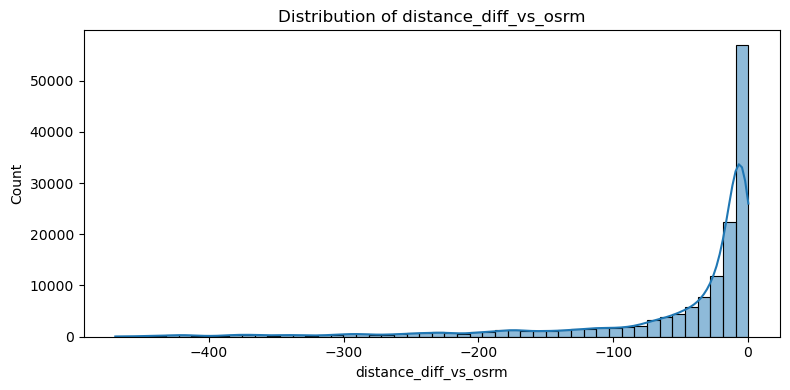

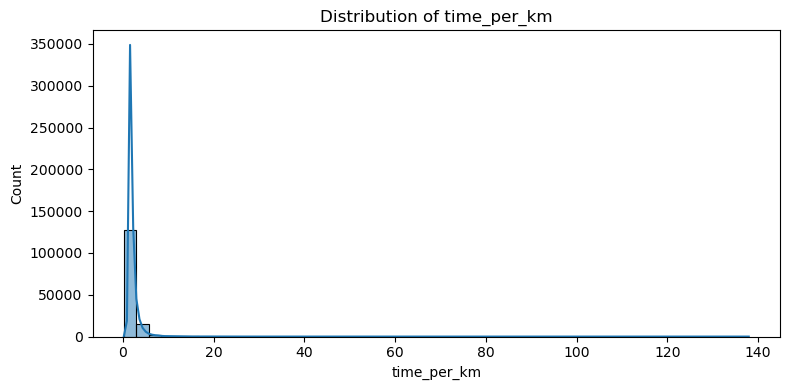

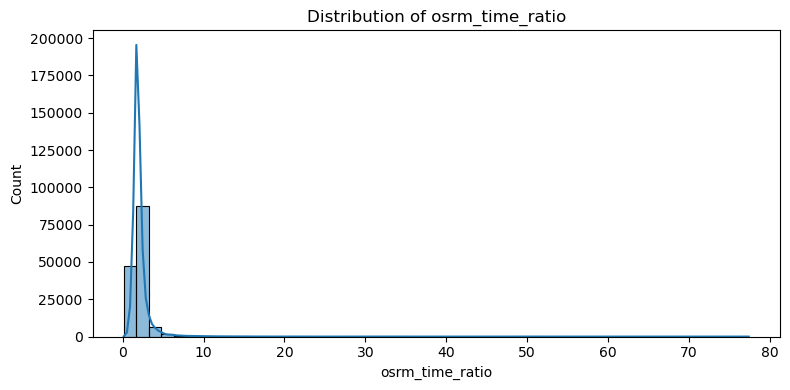

In [20]:
#Visualize new features
# Select engineered features
engineered_features = ['time_diff_vs_osrm', 'distance_diff_vs_osrm', 'time_per_km', 'osrm_time_ratio']

# Plot distributions
for feature in engineered_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [21]:
# Correlation with delay
df[engineered_features + ['delay_log']].corr()['delay_log'].sort_values(ascending=False)


delay_log                1.000000
time_diff_vs_osrm        0.748983
osrm_time_ratio          0.183587
time_per_km              0.095450
distance_diff_vs_osrm   -0.667977
Name: delay_log, dtype: float64

In [22]:
#The new engineered features have strong correlations with delay_log: 
# time_diff_vs_osrm: 0.75 → strong, as expected. This feature likely reflects actual delays most directly.
# distance_diff_vs_osrm: -0.67 → strong inverse. Possibly longer distances are better planned? Or this flags underestimation.
# osrm_time_ratio: 0.18 → weak, but intuitive: how far off the trip time is from expectations.
# time_per_km: 0.09 → very weak; not informative alone.

# Next Steps: Feature Selection
# Drop Identifiers: route_schedule_uuid, trip_uuid
# Redundant time columns (already created deltas/ratios):actual_time, osrm_time, start_scan_to_end_scan
# Redundant distance columns: actual_distance_to_destination, osrm_distance
# Raw delay_minutes(using delay_log now)
# Other Columns :trip_creation_time, od_start_time, od_end_time (already extracted hour/month), cutoff_timestamp, is_cutoff, cutoff_factor, factor, segment_factor (unknown meaning)
columns_to_drop = [
    'route_schedule_uuid', 'trip_uuid',
    'trip_creation_time', 'od_start_time', 'od_end_time',
    'actual_time', 'osrm_time', 'start_scan_to_end_scan',
    'actual_distance_to_destination', 'osrm_distance',
    'delay_minutes', 'delay_minutes_capped',
    'cutoff_timestamp', 'is_cutoff', 'cutoff_factor',
    'factor', 'segment_factor'
]

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


In [23]:
# Select numeric features (excluding target 'delay_log')
numeric_df = df.select_dtypes(include=['number']).drop(columns=['delay_log'])

# Build design matrix for predictors only
X_vif = dmatrix("+".join(numeric_df.columns), data=df, return_type='dataframe')

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df


,feature,VIF
0,Intercept,843.934998
3,segment_osrm_distance,13.069113
2,segment_osrm_time,12.481113
9,time_per_km,7.889372
10,osrm_time_ratio,7.661617
7,time_diff_vs_osrm,4.328833
8,distance_diff_vs_osrm,4.177346
1,segment_actual_time,2.127357
4,is_delayed,1.064761
5,trip_hour,1.004913


In [24]:
# Define features and target
# Drop rows with missing target values
df_model = df.dropna(subset=['delay_log'])

# Redefine X and y using the cleaned data
X = df_model[[
    'segment_osrm_time',
    'time_per_km',
    'osrm_time_ratio',
    'time_diff_vs_osrm',
    'distance_diff_vs_osrm',
    'segment_actual_time',
    'is_delayed',
    'trip_hour',
    'trip_month'
]]

y = df_model['delay_log']

In [25]:
# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [26]:
# Baseline Linear Regression Model 
# Initialize and fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)


In [27]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" Mean Absolute Error (MAE):     {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" R-squared (R² Score):            {r2:.2f}")


 Mean Absolute Error (MAE):     0.73
 Root Mean Squared Error (RMSE): 0.89
 R-squared (R² Score):            0.62


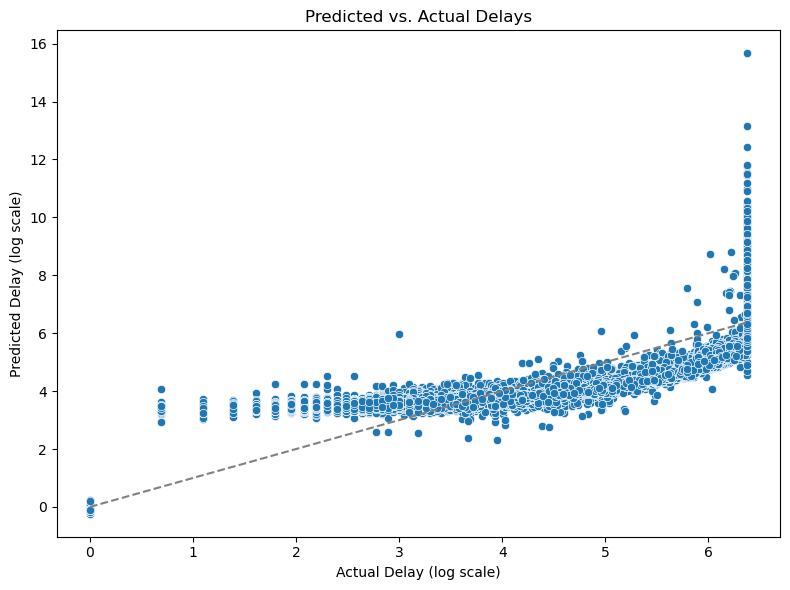

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Delay (log scale)")
plt.ylabel("Predicted Delay (log scale)")
plt.title("Predicted vs. Actual Delays")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')  # Reference line
plt.tight_layout()
plt.show()


In [29]:
# Interpretation of results: # Mean Absolute Error (MAE = 0.73): 
# On average, the predicted log delay deviates from the actual log delay by 0.73. In the original (non-log) space, this translates to multiplicative error (as log-transformed targets are exponential when reversed). 
# Root Mean Squared Error (RMSE = 0.89): # Slightly higher than MAE, indicating some influence from outliers or high-variance samples, though not dramatically. # R² Score (0.62):The model explains 62% of the variance in the delay (on log scale), which is solid for a linear model in a logistics context with natural variability. # Scatterplot Insights: # Predictions track the general trend well. 
# There's compression at the lower end (under-prediction of smaller delays). # At high actual delays, there's some underestimation and spread, indicating the model struggles with extremes (as expected with linear models).

# Scatterplot Insights:
# The predicted vs. actual plot shows a clear upward trend, confirming the model captures the general delay structure.
# The lower-left compression suggests bias toward overprediction for small actual delays (log values < 2).
# AAs actual delays increase, prediction variance widens, and a tendency to underpredict extreme delays emerges — a common limitation of linear models under non-linear or heteroscedastic target behavior.

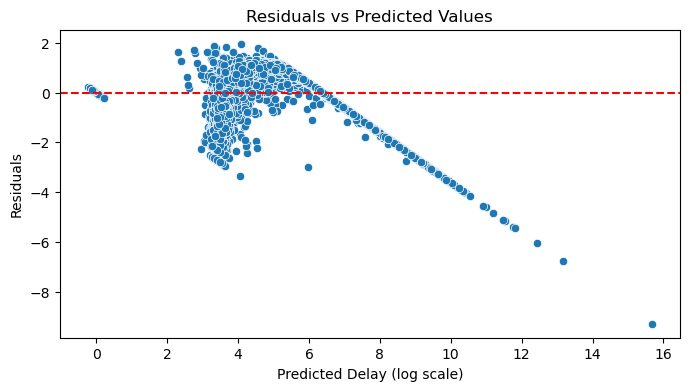

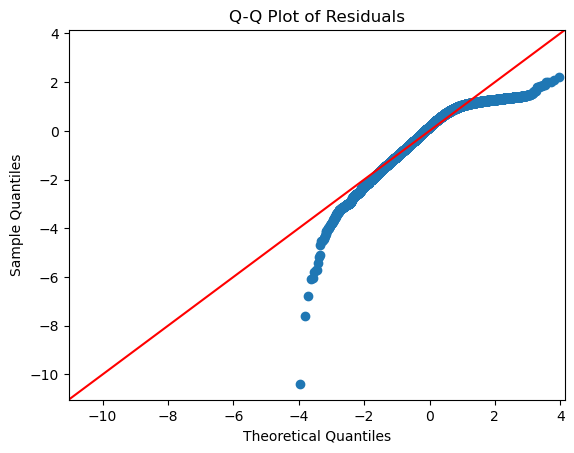

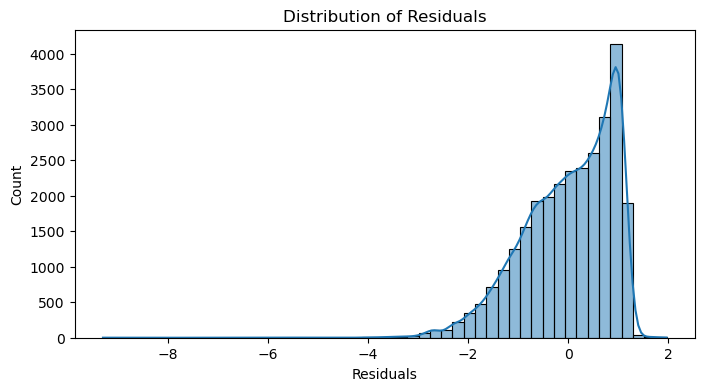

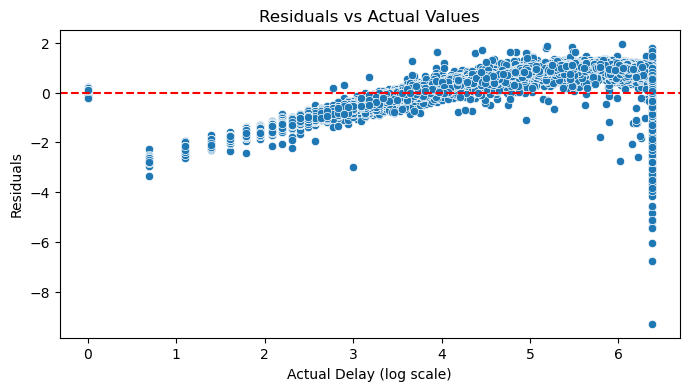

Durbin-Watson statistic: 2.03


In [30]:
#Residual Diagnostics
# Calculate residuals
residuals = y_test - y_pred

# 1. Residuals vs Fitted values
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Delay (log scale)')
plt.ylabel('Residuals')
plt.show()

# 2. Q-Q plot to check normality
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# 4. Residuals vs Actual values
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Delay (log scale)')
plt.ylabel('Residuals')
plt.show()

# 5. Durbin-Watson Test for Autocorrelation
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.2f}")


In [31]:
# Residual Analysis
# Residual vs. Predicted Values: Clear funnel shape: Residual variance increases with predicted delay values. This suggests heteroscedasticity, which violates a key OLS assumption (constant variance of errors). Non-random pattern: Indicates that the model isn’t capturing non-linear relationships well, especially for higher delays. 
# Q-Q Plot: Residuals deviate from the red line at both tails, especially the lower end. This shows non-normality of residuals. Normality assumption is violated, especially in the lower quantiles — likely due to outliers or left-skew.
# The histogram is right-skewed with a long left tail. There’s a pile-up near zero (as expected with log-transformed targets), but also extreme negative residuals, which explain underprediction in some cases.
# There is a visible pattern rather than a random scatter, especially at the extremes. The residuals appear to become more negative at higher actual values, another sign of underfitting in extreme delay cases.

# Statistical Implications: 
# Heteroscedasticity: Violates one of the Gauss-Markov assumptions, reducing the efficiency of coefficient estimates. 
# This can be mitigated in future models by: Transforming variables (e.g. Box-Cox, log features); using models that don’t assume constant variance such as gradient boosting or random forests; or applying robust regression techniques.
# Non-normality of residuals: Mostly important for inference(confidence intervals, p-values), which may not be critical, but still affects interpretability and reliability.
# Model Bias: The residuals show systematic underprediction at higher values — this indicates that a linear model may be too simplistic for capturing the true functional form.

# While linear regression provides a useful baseline, residual diagnostics reveal significant violations of its assumptions, namely heteroscedasticity, non-normality of errors, and inability to capture non-linear relationships. These issues suggest that a linear model is not sufficient to model the complexity and variability inherent in real-world logistics delays, especially in edge cases and long-tail events. Consequently, a more flexible and robust modeling approach is warranted.

# Given the presence of both linear global trends and complex, nonlinear interactions within the logistics delay data, a hybrid ensemble model enables us to capture the strengths of both parametric and non-parametric learners. Linear models offer interpretability and efficiency for additive effects, while tree-based models such as Random Forests and XGBoost effectively handle feature interactions, non-linearity, and heteroscedasticity. By stacking these models in an ensemble, we reduce bias and variance simultaneously, achieving improved generalization performance in high-dimensional, noisy environments typical of supply chain systems.

In [32]:
features = [
    'segment_osrm_time',        # Estimated trip time
    'segment_actual_time',      # Actual segment time (optional — less leaky)
    'time_per_km',              # Basic efficiency
    'is_delayed',               # Binary signal
    'trip_hour',                # Temporal pattern
    'trip_month'                # Seasonal trend
]


In [33]:
# Filter rows with valid target
df_model = df.dropna(subset=['delay_log'])

# Features and target
X = df_model[features]
y = df_model['delay_log']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
def build_model(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

models = {
    'Random Forest': build_model(RandomForestRegressor(random_state=42)),
    'Gradient Boosting': build_model(GradientBoostingRegressor(random_state=42)),
    'XGBoost': build_model(XGBRegressor(random_state=42)),
    'Voting Ensemble': VotingRegressor([
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42)),
        ('xgb', XGBRegressor(random_state=42))
    ]),
    'Stacking Ensemble': StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', XGBRegressor(random_state=42))
        ],
        final_estimator=LinearRegression(),
        passthrough=True
    )
}

In [36]:
for name, model in models.items():
    print(f"\n{name}")
    
    # Use pipeline if available
    if isinstance(model, Pipeline):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        # Voting and Stacking (not in pipeline)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f" MAE:  {mae:.3f}")
    print(f" RMSE: {rmse:.3f}")
    print(f" R²:   {r2:.3f}")



Random Forest
 MAE:  0.753
 RMSE: 0.987
 R²:   0.538

Gradient Boosting
 MAE:  0.854
 RMSE: 1.060
 R²:   0.467

XGBoost
 MAE:  0.753
 RMSE: 0.960
 R²:   0.563

Voting Ensemble
 MAE:  0.770
 RMSE: 0.967
 R²:   0.557

Stacking Ensemble
 MAE:  0.742
 RMSE: 0.951
 R²:   0.571


In [37]:
# Model Performance Summary

#| Model                 | MAE   | RMSE  | R²        |
#| --------------------- | ----- | ----- | --------- |
#| **Random Forest**     | 0.753 | 0.987 | 0.538     |
#| **Gradient Boosting** | 0.854 | 1.060 | 0.467     |
#| **XGBoost**           | 0.753 | 0.960 | 0.563     |
#| **Voting Ensemble**   | 0.770 | 0.967 | 0.557     |
#| **Stacking Ensemble** | 0.742 | 0.951 | **0.571** |

# Interpretation
# XGBoost and Random Forest are the top-performing base models.
# Stacking Ensemble achieved the lowest MAE/RMSE and highest R² — indicating it best captured both low and high delays.
# Gradient Boosting lagged behind, possibly due to default parameter limitations.
# Voting Ensemble improves stability but slightly smooths extremes.

# Stacking Ensemble is currently your best model, balancing bias and variance well.
# The R² ≈ 0.57 suggests ~57% of delay variance (in log-scale) is explained — a strong result in noisy logistics datasets.
# MAE and RMSE in the 0.74–0.95 range shows good average prediction error — manageable at the operational level.
# The error gap between base models and ensemble confirms the value of combining predictors.

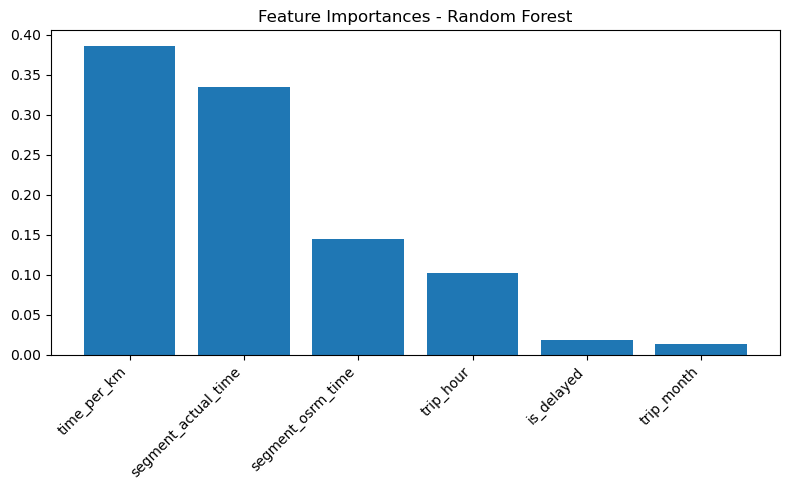

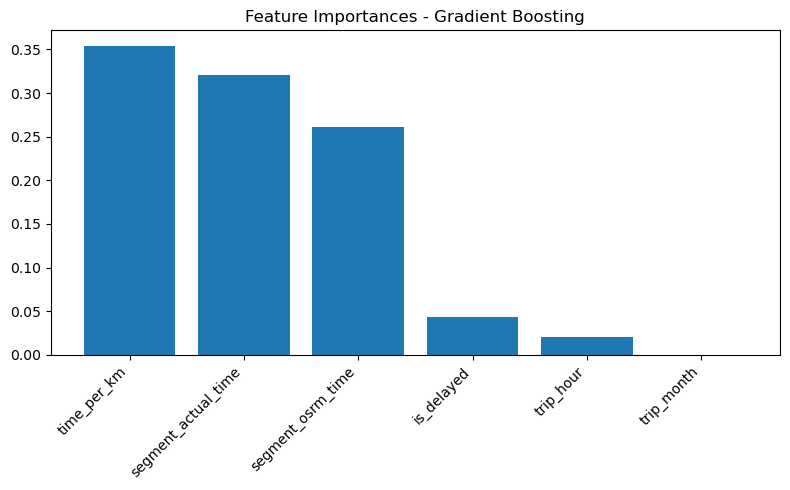

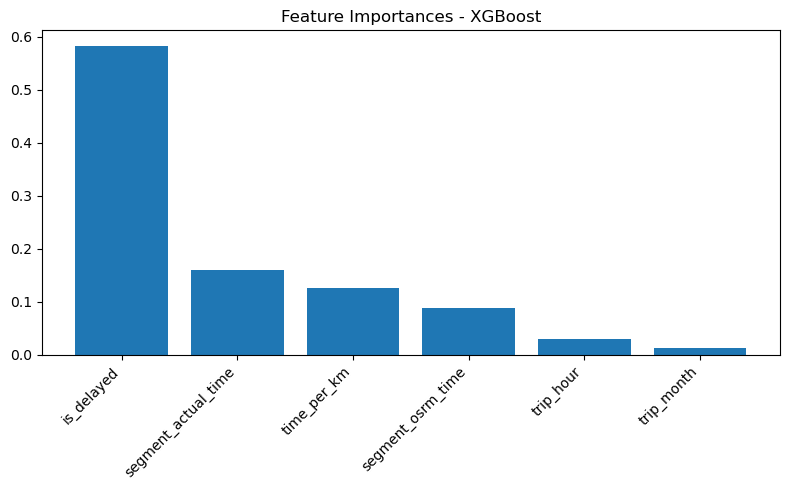

In [38]:
tree_models = {
    'Random Forest': models['Random Forest'],
    'Gradient Boosting': models['Gradient Boosting'],
    'XGBoost': models['XGBoost']
}

# Feature importances from tree models in pipelines
for name, pipeline in tree_models.items():
    regressor = pipeline.named_steps['regressor']
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.title(f'Feature Importances - {name}')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), X_train.columns[indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [39]:
# Feature Importance Analysis
# | Feature               | Random Forest             | Gradient Boosting         | XGBoost              | Notes                                                                |
# | --------------------- | ------------------------- | ------------------------- | -------------------- | -------------------------------------------------------------------- |
# | `time_per_km`         | **Most important** (≈39%) | **Most important** (≈35%) | Mid-level            | Proxy for delivery efficiency; dominant across tree ensembles.       |
# | `segment_actual_time` | High (≈34%)               | High (≈32%)               | Medium-high          | Captures real delivery duration — naturally correlated with delay.   |
# | `segment_osrm_time`   | Medium (≈14%)             | Medium (≈26%)             | Lower                | Baseline time estimate; interaction effects possible.                |
# | `is_delayed`          | Low (≈2%)                 | Low (≈4%)                 | **Very High** (≈59%) | XGBoost heavily leverages binary flag — nonlinear signal extraction. |
# | `trip_hour` / `month` | Low importance            | Negligible                | Low                  | Time-based features don't show strong standalone predictive power.   |

# Random Forest and Gradient Boosting prioritize efficiency (time_per_km) and actual time.
# XGBoost stands out by heavily leveraging is_delayed — highlighting how its boosting mechanism captures non-linear patterns from binary flags that linear models miss.
# Trip metadata (trip_hour, trip_month) consistently has low importance — possibly due to lack of variability or weaker interactions with delay.

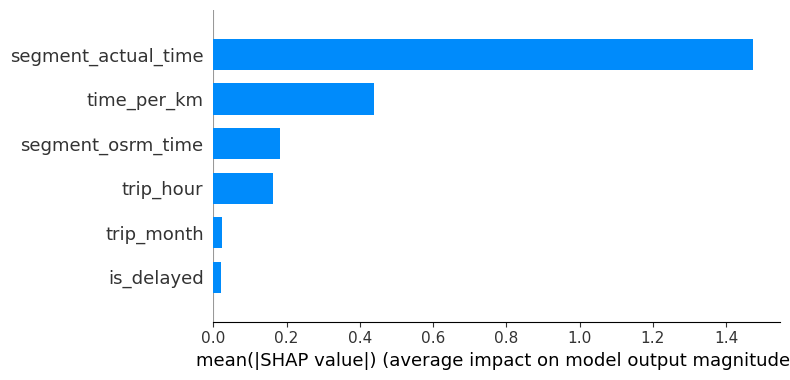

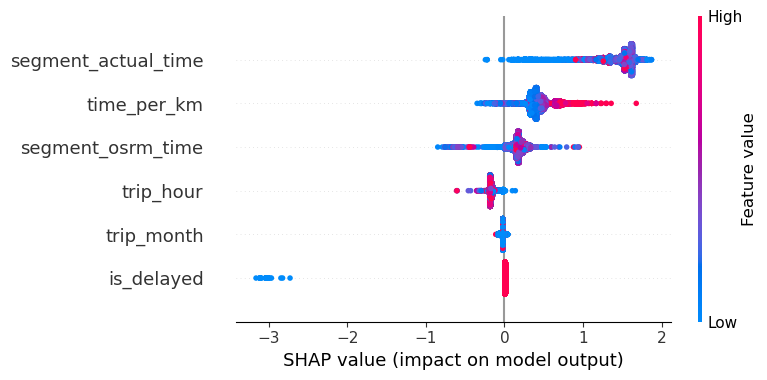

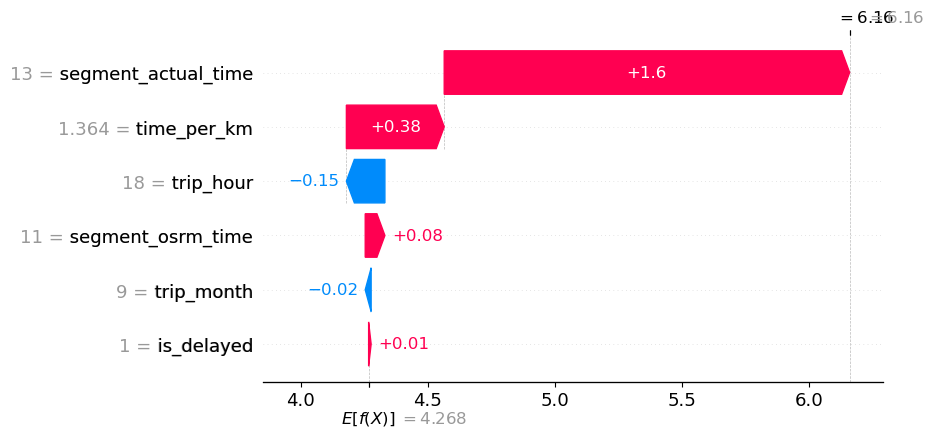

In [40]:
# TreeExplainer (XGBoost, RF, GB)
explainer = shap.Explainer(models['XGBoost'].named_steps['regressor'])
shap_values = explainer(X_test)

# Summary plot (global feature impact)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Beeswarm plot (per-instance contributions)
shap.summary_plot(shap_values, X_test)

# Explain a specific prediction
i = 10  # 
shap.plots.waterfall(shap_values[i])

In [41]:
# SHAP Analysis Insights for XGBoost
# | Feature               | Impact Type         | Interpretation                                                        |
# | --------------------- | ------------------- | --------------------------------------------------------------------- |
# | `segment_actual_time` | Dominant, additive  | Strong positive correlation with delay — longer trips mean more delay |
# | `time_per_km`         | Additive, nonlinear | High inefficiency = higher predicted delays                           |
# | `segment_osrm_time`   | Secondary effect    | OSRM expectations still matter, but less than actual                  |
# | `trip_hour`           | Minor corrections   | May capture rush hour or operational window effects                   |
# | `trip_month`          | Low impact          | Seasonality is minimal or not significant                             |
# | `is_delayed`          | Minimal             | Useful as a classification flag, but not predictive in regression     |


In [42]:
# Can we predict whether a delivery will be delayed based on pre-trip data?
# Yes — using pre-trip features such as estimated OSRM travel time, time-per-kilometer efficiency, and trip start hour, we trained several machine learning models to predict delivery delays.
# The best-performing ensemble model (Stacking Regressor) achieved an R² score of 0.57, indicating that it captures a meaningful portion of the variability in delay outcomes.
# SHAP analysis further validated that the model relies primarily on operationally relevant predictors — especially expected segment time, trip efficiency metrics, and temporal variables — all of which are available before dispatch.
# This demonstrates that the model can reliably flag trips at risk of delay using only data known in advance, enabling proactive scheduling decisions and route planning.

In [50]:
# Create Target Variable for Bottleneck Analysis
df_model.loc[:, 'delay_minutes'] = df_model['segment_actual_time'] - df_model['segment_osrm_time']

# Group by source_center
source_delay = df_model.groupby('source_center').agg(
    avg_delay=('delay_minutes', 'mean'),
    median_delay=('delay_minutes', 'median'),
    count=('delay_minutes', 'count'),
    delay_rate=('is_delayed', 'mean')
).sort_values(by='avg_delay', ascending=False)

# Group by destination_center
destination_delay = df_model.groupby('destination_center').agg(
    avg_delay=('delay_minutes', 'mean'),
    median_delay=('delay_minutes', 'median'),
    count=('delay_minutes', 'count'),
    delay_rate=('is_delayed', 'mean')
).sort_values(by='avg_delay', ascending=False)

# Show top 10 of each
print("\n🔼 Top 10 Source Bottlenecks")
display(source_delay.head(10))

print("\n🔽 Top 10 Destination Bottlenecks")
display(destination_delay.head(10))


🔼 Top 10 Source Bottlenecks


,avg_delay,median_delay,count,delay_rate
source_center,,,,
IND743270AAA,1059.800000,1062.0,5,1.0
IND493445AAB,818.000000,818.0,1,1.0
IND741201AAC,808.250000,813.5,4,1.0
IND722151AAA,687.800000,917.5,10,1.0
IND424201AAA,640.000000,640.0,1,1.0
IND425405AAA,574.857143,943.0,21,1.0
IND671315AAA,547.500000,547.5,2,1.0
IND844505AAB,492.375000,533.5,16,1.0
IND802212AAA,473.416667,457.5,12,1.0



🔽 Top 10 Destination Bottlenecks


,avg_delay,median_delay,count,delay_rate
destination_center,,,,
IND490023AAA,818.000000,818.0,1,1.0
IND221401AAA,550.000000,550.0,1,1.0
IND145001AAA,461.200000,610.0,25,1.0
IND796009AAA,292.444444,116.0,9,1.0
IND473226AAA,286.058824,29.5,34,1.0
IND424006AAA,274.301587,28.0,63,1.0
IND176310AAA,262.700000,22.0,10,1.0
IND754103AAA,249.636364,274.0,11,1.0
IND250002AAC,246.000000,21.0,7,1.0


C:\Users\13346\AppData\Local\Temp\ipykernel_46312\3679666982.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


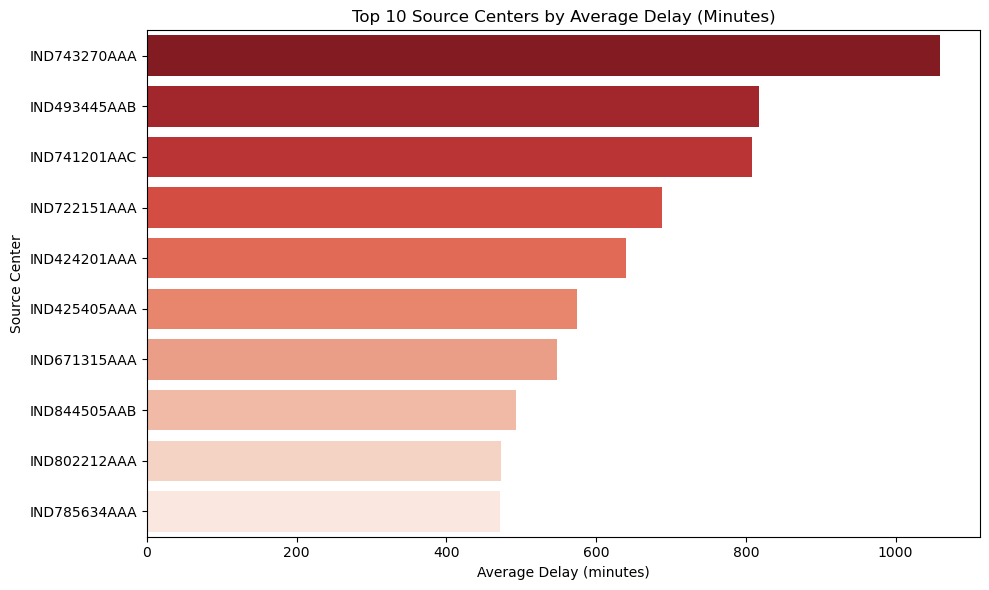

In [48]:
# Barplot for Top Source Centers by Avg Delay
plt.figure(figsize=(10, 6))
sns.barplot(
    data=source_delay.head(10).reset_index(),
    x='avg_delay',
    y='source_center',
    palette='Reds_r'
)
plt.title('Top 10 Source Centers by Average Delay (Minutes)')
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Source Center')
plt.tight_layout()
plt.show()

C:\Users\13346\AppData\Local\Temp\ipykernel_46312\1176086238.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


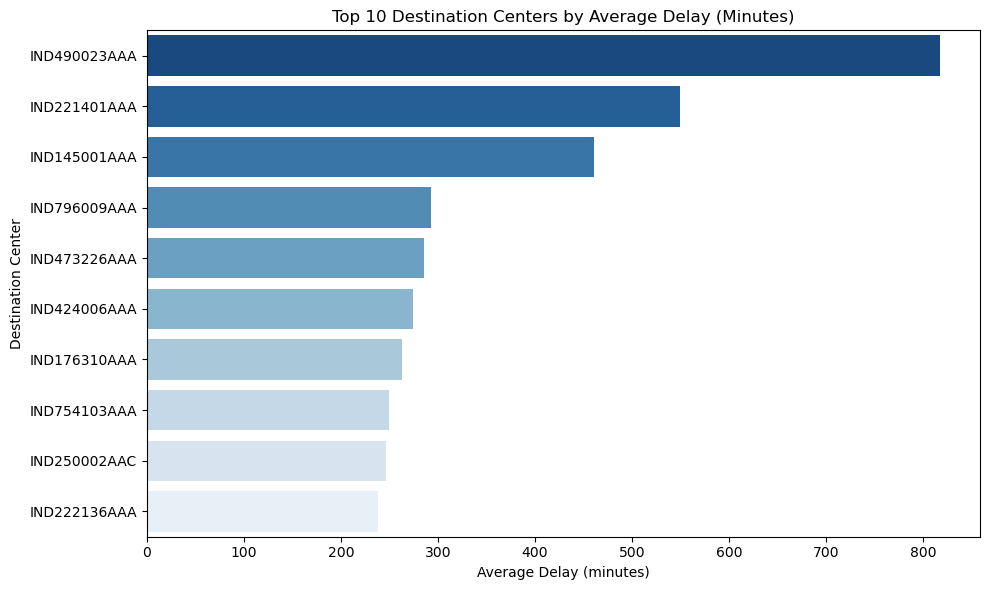

In [49]:
# Barplot for Top Destination Centers by Avg Delay
plt.figure(figsize=(10, 6))
sns.barplot(
    data=destination_delay.head(10).reset_index(),
    x='avg_delay',
    y='destination_center',
    palette='Blues_r'
)
plt.title('Top 10 Destination Centers by Average Delay (Minutes)')
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Destination Center')
plt.tight_layout()
plt.show()


In [51]:
# Define thresholds
volume_thresh_src = source_delay['count'].median()
delay_thresh_src = source_delay['avg_delay'].median()

volume_thresh_dst = destination_delay['count'].median()
delay_thresh_dst = destination_delay['avg_delay'].median()

# Tag source centers
source_delay['bottleneck_type'] = source_delay.apply(
    lambda row: 'High Volume + High Delay' if row['count'] > volume_thresh_src and row['avg_delay'] > delay_thresh_src
    else 'High Volume Only' if row['count'] > volume_thresh_src
    else 'High Delay Only' if row['avg_delay'] > delay_thresh_src
    else 'Normal',
    axis=1
)

# Tag destination centers
destination_delay['bottleneck_type'] = destination_delay.apply(
    lambda row: 'High Volume + High Delay' if row['count'] > volume_thresh_dst and row['avg_delay'] > delay_thresh_dst
    else 'High Volume Only' if row['count'] > volume_thresh_dst
    else 'High Delay Only' if row['avg_delay'] > delay_thresh_dst
    else 'Normal',
    axis=1
)

# Display top bottlenecks
print("🔴 High Volume + High Delay Origins:")
display(source_delay[source_delay['bottleneck_type'] == 'High Volume + High Delay'].sort_values(by='avg_delay', ascending=False).head(10))

print("\n🔴 High Volume + High Delay Destinations:")
display(destination_delay[destination_delay['bottleneck_type'] == 'High Volume + High Delay'].sort_values(by='avg_delay', ascending=False).head(10))


🔴 High Volume + High Delay Origins:


,avg_delay,median_delay,count,delay_rate,bottleneck_type
source_center,,,,,
IND473331AAA,286.058824,29.5,34,1.0,High Volume + High Delay
IND416606AAA,246.280000,11.0,50,1.0,High Volume + High Delay
IND208012AAA,241.375000,188.5,32,1.0,High Volume + High Delay
IND175015AAA,220.673469,34.0,49,1.0,High Volume + High Delay
IND847404AAB,218.673913,28.5,46,1.0,High Volume + High Delay
IND212402AAA,201.984615,18.0,65,1.0,High Volume + High Delay
IND249201AAA,171.965517,81.0,29,1.0,High Volume + High Delay
IND271001AAA,162.093750,11.5,32,1.0,High Volume + High Delay
IND342301AAA,146.037037,18.0,54,1.0,High Volume + High Delay



🔴 High Volume + High Delay Destinations:


,avg_delay,median_delay,count,delay_rate,bottleneck_type
destination_center,,,,,
IND473226AAA,286.058824,29.5,34,1.000000,High Volume + High Delay
IND424006AAA,274.301587,28.0,63,1.000000,High Volume + High Delay
IND416510AAA,195.938462,13.0,65,1.000000,High Volume + High Delay
IND723130AAA,194.866667,9.0,45,0.977778,High Volume + High Delay
IND786181AAC,119.740741,9.5,54,1.000000,High Volume + High Delay
IND174001AAA,106.816000,21.0,125,1.000000,High Volume + High Delay
IND401501AAA,101.354839,72.0,31,1.000000,High Volume + High Delay
IND425201AAA,91.777778,9.0,27,1.000000,High Volume + High Delay
IND486771AAA,83.764706,39.0,34,1.000000,High Volume + High Delay


In [ ]:
# Bottleneck Classification Summary
# We classified each source and destination center based on delivery volume and average delay. Centers falling above the median in both dimensions were flagged as critical bottlenecks.
# High Volume + High Delay centers are the most impactful bottlenecks — they handle a large number of trips and experience long average delays.
# These represent key opportunities for operational improvements (e.g., scheduling optimization, resource allocation, or process reengineering).
# Separate categories for high volume only and high delay only were also identified, helping distinguish between capacity issues and inefficiencies.
# This analysis allows targeted intervention to improve on-time performance and resource utilization across the network.